In [ ]:
#Conexão com Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Instalação das dependências
!pip install tensorflow==2.8.0 tensorflow-addons==0.16.1

import tensorflow as tf
import tensorflow_addons as tfa
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras import layers, models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 34.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

In [ ]:
def convert_to_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return tf.image.grayscale_to_rgb(grayscale_image)

In [ ]:
def load_image(file_path, grayscale=False):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [256, 256])
    if grayscale:
        image = convert_to_grayscale(image)
    image = (image / 127.5) - 1
    return image

In [ ]:
def load_dataset(path, grayscale=False):
    dataset = tf.data.Dataset.list_files(path + '/*.jpeg')
    dataset = dataset.map(lambda x: load_image(x, grayscale), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

In [ ]:
#Montagem dos Datasets
path_to_trainA = '/content/drive/MyDrive/TCC/Desenhos/Treino'
path_to_trainB = '/content/drive/MyDrive/TCC/Real/Treino'
path_to_testA = '/content/drive/MyDrive/TCC/Desenhos/Teste'
path_to_testB = '/content/drive/MyDrive/TCC/Real/Teste'

trainA_dataset = load_dataset(path_to_trainA, grayscale=False)  # Modelagem convertida para P&B
trainB_dataset = load_dataset(path_to_trainB, grayscale=False) # Real continua colorido
testA_dataset = load_dataset(path_to_testA, grayscale=False)    # Modelagem convertida para P&B
testB_dataset = load_dataset(path_to_testB, grayscale=False)   # Real continua colorido

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(tfa.layers.InstanceNormalization())
    return result

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(512, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(1, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# Definir funções de loss e otimizadores
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
LAMBDA = 10

In [ ]:
def cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# Função para salvar e exibir imagens geradas separadamente
def save_and_display_images(model_g, model_f, test_input, target, epoch, output_dir):
    # Gerar as imagens
    prediction_g = model_g(test_input, training=True)  # Modelagem para Real
    prediction_f = model_f(target, training=True)      # Real para Modelagem

    # Converter tensores para arrays NumPy
    display_list = [
        test_input[0].numpy(),
        target[0].numpy(),
        prediction_g[0].numpy(),
        prediction_f[0].numpy()
    ]

    title = ['Input Image (Modelagem)', 'Ground Truth (Real)', 'Generated (Real)', 'Generated (Modelagem)']

    # Exibir as imagens
    plt.figure(figsize=(12, 12))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)  # Desnormaliza para [0, 1]
        plt.axis('off')
    plt.show()

    # Salvar as imagens separadamente
    img_names = ['input_modelagem', 'ground_truth_real', 'generated_real', 'generated_modelagem']
    for i, img in enumerate(display_list):
        output_path = os.path.join(output_dir, f'epoch_{epoch+1}_{img_names[i]}.png')
        plt.imsave(output_path, (img * 0.5) + 0.5)  # Salva desnormalizado em [0, 1]

# Caminho onde as imagens de saída serão salvas
output_dir = '/content/drive/MyDrive/TCC/outputs'
os.makedirs(output_dir, exist_ok=True)  # Certifique-se de que o diretório existe

In [ ]:
# Diretório para salvar checkpoints
checkpoint_dir = '/content/drive/MyDrive/TCC/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [ ]:
# Adicionando uma variável para armazenar a época no checkpoint
checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                                 generator_f=generator_f,
                                 discriminator_x=discriminator_x,
                                 discriminator_y=discriminator_y,
                                 generator_g_optimizer=generator_g_optimizer,
                                 generator_f_optimizer=generator_f_optimizer,
                                 discriminator_x_optimizer=discriminator_x_optimizer,
                                 discriminator_y_optimizer=discriminator_y_optimizer,
                                 epoch=tf.Variable(0))


In [ ]:
## Função de treinamento
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss


checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                                 generator_f=generator_f,
                                 discriminator_x=discriminator_x,
                                 discriminator_y=discriminator_y,
                                 generator_g_optimizer=generator_g_optimizer,
                                 generator_f_optimizer=generator_f_optimizer,
                                 discriminator_x_optimizer=discriminator_x_optimizer,
                                 discriminator_y_optimizer=discriminator_y_optimizer,
                                 epoch=tf.Variable(0))  # Adicionando o número da época

checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# Restaurar o checkpoint mais recente, se existir
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print(f'Checkpoint restaurado de: {checkpoint_manager.latest_checkpoint}, iniciando da época {int(checkpoint.epoch)}')
else:
    print('Iniciando o treinamento do zero.')


Checkpoint restaurado de: /content/drive/MyDrive/TCC/checkpoints/ckpt-86, iniciando da época 86


In [ ]:
def generate_images(model, test_input, target):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)  # Desnormalizar de volta para 0-1
        plt.axis('off')
    plt.show()

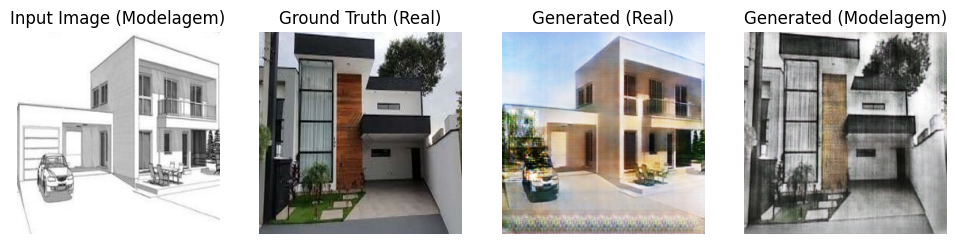

Checkpoint salvo em: /content/drive/MyDrive/TCC/checkpoints/ckpt-100
Time taken for epoch 100 is 1776.06 sec


In [ ]:
# Treinamento principal
EPOCHS = 100

for epoch in range(int(checkpoint.epoch), EPOCHS):
    start = time.time()

    for n, (real_x, real_y) in enumerate(tf.data.Dataset.zip((trainA_dataset, trainB_dataset))):
        losses = train_step(real_x, real_y)
        print('.', end='')

    clear_output(wait=True)

    # Gerar, salvar e exibir imagens a cada época
    test_input = next(iter(testA_dataset))
    target = next(iter(testB_dataset))
    save_and_display_images(generator_g, generator_f, test_input, target, epoch, output_dir)

    # Atualizar o número da época no checkpoint e salvar-
    checkpoint.epoch.assign(epoch + 1)
    checkpoint_manager.save()
    print(f"Checkpoint salvo em: {checkpoint_manager.latest_checkpoint}")

    print(f'Time taken for epoch {epoch+1} is {time.time()-start:.2f} sec')